In [3]:
import numpy as np
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import math

import os

#from PIL import Image
from tqdm import tqdm

import adios2 as ad2
import xgc4py
import nanopq
#from torchsummary import summary

In [4]:
def draw(frame):
    x = np.linspace(0, 38, 39)
    y = np.linspace(0, 38, 39)
    X, Y = np.meshgrid(x, y)
    plt.imshow(frame, origin='lower')
    #plt.imshow(frame, origin='upper')
    plt.colorbar()
    plt.contour(X, Y, frame, 5, origin='image', colors='white', alpha=0.5)

In [5]:
with ad2.open('./dataset/xgc.mesh.bp', 'r') as f:
    nnodes = int(f.read('n_n', ))
    ncells = int(f.read('n_t', ))
    rz = f.read('rz')
    conn = f.read('nd_connect_list')
    psi = f.read('psi')
    nextnode = f.read('nextnode')
    epsilon = f.read('epsilon')
    node_vol = f.read('node_vol')
    node_vol_nearest = f.read('node_vol_nearest')
    psi_surf = f.read('psi_surf')
    surf_idx = f.read('surf_idx')
    surf_len = f.read('surf_len')

r = rz[:,0]
z = rz[:,1]
print (nnodes)

16395


In [7]:
timestep = 100
with ad2.open('dataset/d3d_coarse_v2_{}.bp'.format(timestep), 'r') as f:
    i_f = f.read('i_f')
i_f.shape

(8, 16395, 39, 39)

In [34]:
import os
import errno

dirname = './results/AET3d/v2_{}/model/'.format(timestep)
os.makedirs(os.path.dirname(dirname), exist_ok=True)
dirname = './results/AET3d/v2_{}/output/evaluations/'.format(timestep)
os.makedirs(os.path.dirname(dirname), exist_ok=True)
dirname = './results/AET3d/v2_{}/output/residuals/'.format(timestep)
os.makedirs(os.path.dirname(dirname), exist_ok=True)

In [5]:
exdir = '/gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/'
xgcexp = xgc4py.XGC(exdir)

Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.mesh.bp
Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.f0.mesh.bp
Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.fluxavg.bp
Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.mesh.bp
Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.grad_rz.bp
Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.bfield.bp
Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.f0.mesh.bp
Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.f0analysis.static.bp
Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.equil.bp
Reading: /gpfs/alpine/proj-shared/csc143/jyc/summit/xgc-deeplearning/d3d_coarse_v2/xgc.units.bp
sml_00_npsi, sml_inps

In [6]:
xgcexp = xgc4py.XGC('./dataset')

Reading: ./dataset/xgc.mesh.bp
Reading: ./dataset/xgc.f0.mesh.bp
Reading: ./dataset/xgc.fluxavg.bp
Reading: ./dataset/xgc.mesh.bp
Reading: ./dataset/xgc.grad_rz.bp
Reading: ./dataset/xgc.bfield.bp
Reading: ./dataset/xgc.f0.mesh.bp
Reading: ./dataset/xgc.f0analysis.static.bp
Reading: ./dataset/xgc.equil.bp
Reading: ./dataset/xgc.units.bp
sml_00_npsi, sml_inpsi, sml_outpsi= 101 0.0 0.29281518594779
sml_nphi_total= 8
sml_grid_nrho= 4
sml_exclude_private= True
sml_rhomax= 0.008


In [7]:
all_planes = np.copy(i_f)

# changed for separate tucker

mu = np.mean(all_planes, axis=(2,3))
sig = np.std(all_planes, axis=(2,3))
all_planes = (all_planes - mu[:,:,np.newaxis, np.newaxis])/sig[:,:,np.newaxis, np.newaxis]
print(all_planes.shape, mu.shape, sig.shape)
#del all_planes

(8, 16395, 39, 39) (8, 16395) (8, 16395)


In [8]:
Epochs = 500
Lr_Rate = 1e-3
Batch_Size = 128

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent):
        super(Autoencoder, self).__init__()
        
        self.enc1 = nn.Linear(in_features=input_dim, out_features=latent)
    
    def encode(self, x):
        x = self.enc1(x)        
        return x
    
    def decode(self, x):        
        x = F.linear(x, weight=self.enc1.weight.transpose(0,1))        
        return x

    def forward(self, x):
        
        latent = self.encode(x)
        recon = self.decode(latent)

        return recon

In [10]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [6]:
from torchsummary import summary

#latent_dims = [5, 10, 20, 30]
#latent_dims = [45, 60, 90, 120]
latent_dims = [300]
#latent_dims = [150, 180, 210, 240, 300]
for latent in latent_dims:
    model = Autoencoder(1521, latent)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=Lr_Rate)
    device = get_device()
    model.to(device)
    print('laent space: ', latent)
    print(summary(model, (1, 1521)))

laent space:  300
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 300]         456,600
Total params: 456,600
Trainable params: 456,600
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.74
Estimated Total Size (MB): 1.75
----------------------------------------------------------------
None


In [11]:
def training(model, train_loader, Epochs, latent_dim, timestep, plane_idx):
    train_loss = []
    best_loss = 100
    for epoch in range(Epochs):
        running_loss = 0.0
        for data in train_loader:
            data = data[0].to(device)            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.6f}'.format(
            epoch+1, Epochs, loss))
        if (loss < best_loss):
            torch.save(model.state_dict(), './results/AET3d/v2_{}/model/AET3d_plane{}_latent{}_best_parameters.pt'.format(timestep,plane_idx,latent_dim))
            best_loss = loss
            print('best loss: ', best_loss)

    return train_loss

In [12]:
def test_reconstruct(model, test_loader, num_instance, input_dim):
    #reconstructions = np.zeros((78*16,num_coeffs))
    reconstructions = []
    
    temp = 0
    for batch in test_loader:
        data = batch[0]
        data = data.to(device)
        outputs = model(data)
        if (temp == 0):
            print('Tensor type:', outputs[0][0].dtype)
            temp += 1
        reconstructions.append(outputs.cpu().data.numpy())
        #reconstructions[count] = outputs.cpu().numpy()
        #count = count + 1
        
    decoded_vectors = np.zeros((num_instance,input_dim), dtype=np.float32)
    count = 0
    for i in range(len(reconstructions)):
        for j in range(len(reconstructions[i])):
            decoded_vectors[count] = np.float32(reconstructions[i][j])
            count = count + 1
    
    return decoded_vectors

In [13]:
def encoding(model, test_loader, num_instance, latent_dim):
    #reconstructions = np.zeros((78*16,num_coeffs))
    latent_vectors = []
    
    #count = 0
    for batch in test_loader:
        data = batch[0]
        data = data.to(device)
        outputs = model.encode(data)
        latent_vectors.append(outputs.cpu().data.numpy())
        #reconstructions[count] = outputs.cpu().numpy()
        #count = count + 1
    
    encoded_vectors = np.zeros((num_instance,latent_dim), dtype=np.float32)
    count = 0
    for i in range(len(latent_vectors)):
        for j in range(len(latent_vectors[i])):
            encoded_vectors[count] = np.float32(latent_vectors[i][j])
            count = count + 1  
    
    return encoded_vectors

In [14]:
def decoding(model, test_loader, num_instance, input_dim):
    #reconstructions = np.zeros((78*16,num_coeffs))
    reconstructions = []    

    for batch in test_loader:
        data = batch[0]
        data = data.to(device)
        outputs = model.decode(data)
        reconstructions.append(outputs.cpu().data.numpy())
        #reconstructions[count] = outputs.cpu().numpy()
        #count = count + 1
    
    decoded_vectors = np.zeros((num_instance,input_dim), dtype=np.float32)
    count = 0
    for i in range(len(reconstructions)):
        for j in range(len(reconstructions[i])):
            decoded_vectors[count] = np.float32(reconstructions[i][j])
            count = count + 1
    
    return decoded_vectors

In [15]:
def tucker(data):
    shape = [data.shape[-2], data.shape[-1]]
    
    X_1 = np.transpose(data, (1, 2, 0))
    X_1 = X_1.reshape(X_1.shape[0], X_1.shape[1]* X_1.shape[2])
    #U_1, _, _ = LA.svd(X_1)
        
    X_2 = np.transpose(data, (2, 1, 0))
    X_2 = X_2.reshape(X_2.shape[0], X_2.shape[1]* X_2.shape[2])
    #U_2, _, _ = LA.svd(X_2)
    
    C_1 = np.zeros(shape)
    for i in tqdm(range(X_1.shape[1]), desc="finding C_1"):
        column = X_1[:,i]
        C_1 += np.outer(column, column.T)
    
    C_2 = np.zeros(shape)
    for i in tqdm(range(X_2.shape[1]), desc="finding C_2"):
        row = X_2[:,i]
        C_2 += np.outer(row, row.T)
        
    U_1 = LA.eigh(C_1)[1]
    U_2 = LA.eigh(C_2)[1]
    
    coeff_tucker = np.zeros(data.shape)
    for i, img in enumerate(tqdm(data)):
        for j in range(U_1.shape[1]) :
            for k in range(U_2.shape[1]):
                coeff_tucker[i, j, k] = np.dot(U_1.T[j], np.dot(img, U_2.T[k]))
                
    return coeff_tucker, [U_1, U_2]

def tucker_top_coeffs(coeff_tucker, num_coeffs):
    sum_coeff_tucker= np.zeros((39, 39))
    for j in range(39):
        for k in range(39):
            sum_coeff_tucker[j, k] = sum(np.abs(coeff_tucker[:, j, k]))
            
    max_index_pair_tucker = np.dstack(np.unravel_index(np.argsort(sum_coeff_tucker.ravel())[::-1], (39, 39)))
    max_index_pair_tucker = np.dstack(np.unravel_index(np.argsort(sum_coeff_tucker.ravel())[::-1], (39, 39)))
    
    max_index_pair_tucker = max_index_pair_tucker.reshape((1521, 2))
    top_index_pair_tucker = max_index_pair_tucker[:num_coeffs]
    
    return top_index_pair_tucker

def compute_basis(coeff_tucker, top_index_pair_tucker, factors, train_num):
    U_1 = factors[0]
    U_2 = factors[1]
    basis_product_reduced = np.array([np.outer(U_1.T[pair[0]], U_2.T[pair[1]]) for pair in top_index_pair_tucker])
    basis_product_reduced = basis_product_reduced.reshape((basis_product_reduced.shape[0], basis_product_reduced.shape[1]*basis_product_reduced.shape[2]))
    basis_product_reduced = basis_product_reduced.transpose()    
    
    return basis_product_reduced

def to_tucker_basis(coeff_tucker, top_index_pair_tucker, train_num, num_coeffs):    
    coeff_tucker_reduced = np.zeros((train_num, num_coeffs))
    for i in range(train_num):
        for j, pair in enumerate(top_index_pair_tucker):
            coeff_tucker_reduced[i,j]= coeff_tucker[i, pair[0], pair[1]]
            
    return coeff_tucker_reduced

In [16]:
timestep

1000

In [17]:
print('data timestep: ', timestep)
for p in range(8):    
    X_train = all_planes[p]
    #X_train = i_f[p]
    plane_idx = p
    print('Plane idx: ', plane_idx)
    print('X_train shape: ', X_train.shape)
    
    train_num = X_train.shape[0]
    
    tqdm.write('converting data to tucker basis...')
    coeff_tucker, factors = tucker(X_train)
    
    Num_coeffs = [1521]
    
    for num_coeffs in Num_coeffs:
        
        tqdm.write('tucker_coeffs: '+str(num_coeffs))
        
        top_index_pair_tucker = tucker_top_coeffs(coeff_tucker, num_coeffs)
        basis_product = compute_basis(coeff_tucker, top_index_pair_tucker, factors, train_num)
        print("basis product shape: ", basis_product.shape)
        np.save('./results/AET3d/v2_{}/basis_product_{}_plane{}.npy'.format(timestep, num_coeffs, plane_idx), basis_product)
        X_train_tucker = to_tucker_basis(coeff_tucker, top_index_pair_tucker, train_num, num_coeffs)
        print('X_train_tucker shape: ', X_train_tucker.shape)
        np.save('./results/AET3d/v2_{}/X_train_tucker_{}_plane{}.npy'.format(timestep, num_coeffs, plane_idx), X_train_tucker)

data timestep:  1000
Plane idx:  0
X_train shape:  (16395, 39, 39)
converting data to tucker basis...


100%|██████████| 16395/16395 [01:04<00:00, 253.88it/s]


tucker_coeffs: 1521
basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)
Plane idx:  1
X_train shape:  (16395, 39, 39)
converting data to tucker basis...


100%|██████████| 16395/16395 [01:04<00:00, 254.34it/s]


tucker_coeffs: 1521
basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)
Plane idx:  2
X_train shape:  (16395, 39, 39)
converting data to tucker basis...


100%|██████████| 16395/16395 [01:04<00:00, 252.80it/s]


tucker_coeffs: 1521
basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)
Plane idx:  3
X_train shape:  (16395, 39, 39)
converting data to tucker basis...


100%|██████████| 16395/16395 [01:04<00:00, 252.44it/s]


tucker_coeffs: 1521
basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)
Plane idx:  4
X_train shape:  (16395, 39, 39)
converting data to tucker basis...


100%|██████████| 16395/16395 [01:04<00:00, 252.74it/s]


tucker_coeffs: 1521
basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)
Plane idx:  5
X_train shape:  (16395, 39, 39)
converting data to tucker basis...


100%|██████████| 16395/16395 [01:04<00:00, 253.15it/s]


tucker_coeffs: 1521
basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)
Plane idx:  6
X_train shape:  (16395, 39, 39)
converting data to tucker basis...


100%|██████████| 16395/16395 [01:04<00:00, 254.38it/s]


tucker_coeffs: 1521
basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)
Plane idx:  7
X_train shape:  (16395, 39, 39)
converting data to tucker basis...


100%|██████████| 16395/16395 [01:04<00:00, 253.01it/s]


tucker_coeffs: 1521
basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)


In [21]:
factors[0].shape, top_index_pair_tucker.shape, coeff_tucker.shape

((39, 39), (1521, 2), (16395, 39, 39))

In [23]:
sum_coeff_tucker= np.zeros((39, 39))
for j in range(39):
    for k in range(39):
        sum_coeff_tucker[j, k] = sum(np.abs(coeff_tucker[:, j, k]))

print(sum_coeff_tucker.shape)
max_index_pair_tucker = np.dstack(np.unravel_index(np.argsort(sum_coeff_tucker.ravel())[::-1], (39, 39)))
print(max_index_pair_tucker.shape)
max_index_pair_tucker = max_index_pair_tucker.reshape((1521, 2))
print(max_index_pair_tucker.shape)

(39, 39)
(1, 1521, 2)
(1521, 2)


In [23]:
print("basis product shape: ", basis_product.shape)
print('X_train_tucker shape: ', X_train_tucker.shape)

basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)


In [24]:
X_train = X_train_tucker@basis_product.T
print(X_train.shape)
X_train = X_train.reshape(16395,39,39)
print(X_train.shape)

(16395, 1521)
(16395, 39, 39)


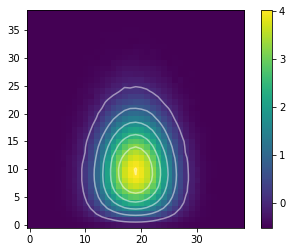

In [25]:
draw(all_planes[7][12050])

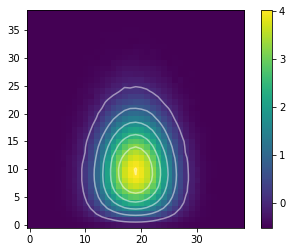

In [26]:
draw(X_train[12050])

In [ ]:
# AET 3d - Per plane, Full Tucker coeffs

#latent_dims = [4, 8, 12, 16, 24, 32, 48, 64, 80, 96, 112, 128, 160, 192, 224, 256, 320]
#latent_dims = [5, 10, 15, 20, 25, 30, 45, 60, 75, 90, 105, 130, 145, 160, 190, 220, 250, 280, 320]
#latent_dims = [1, 2, 3, 5, 10, 20, 30, 45, 60, 90, 120, 150, 180, 210, 240, 300]
latent_dims = [5, 10, 20, 30, 45, 60, 90, 120, 150, 180, 210, 240, 300]

#latent_dims = []


pq_dic = []
pq_var = [16]
pq_bits = [4]

#pq_var = [16]
#pq_bits = [4]

#AET3d_all = np.zeros((8,len(pq_bits),len(latent_dims),16395,39,39))
#print('AET3d shape: ', AET3d_all.shape)

for j in range(len(pq_var)):
    pq_bit = pq_bits[j]
    print('pqbit: ', pq_bit)
    
    for p in range(8):
        print('data timestep: ', timestep)
        #X_train = all_planes[p]
        #X_train = i_f[p]
        plane_idx = p
        
        print('plane idx: ', plane_idx)
        
        Num_coeffs = [1521]
        
        for num_coeffs in Num_coeffs:
            
            tqdm.write('tucker_coeffs: '+str(num_coeffs))
            
            basis_product = np.load('./results/AET3d/v2_{}/basis_product_{}_plane{}.npy'.format(timestep, num_coeffs, p))            
            print("basis product shape: ", basis_product.shape)
            
            X_train_tucker = np.load('./results/AET3d/v2_{}/X_train_tucker_{}_plane{}.npy'.format(timestep, num_coeffs, p))
            print('X_train_tucker shape: ', X_train_tucker.shape)
            print('X_train max avg: ', np.max(X_train_tucker), np.average(X_train_tucker))
            train_num = X_train_tucker.shape[0]
            
            training_data_tucker = torch.utils.data.TensorDataset(torch.Tensor(X_train_tucker))
            
            training_loader_tucker = DataLoader(training_data_tucker,
                                                batch_size=Batch_Size,
                                                shuffle=False,
                                                pin_memory=True)
            
            AET3d_recon = np.zeros((len(latent_dims),train_num,39,39))
            #AET3d_encode = []
            
            for i in range(len(latent_dims)):            
                latent_dim = latent_dims[i]
                model = Autoencoder(X_train_tucker.shape[1], latent_dim)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=Lr_Rate)
                device = get_device()
                model.to(device)
                print(model)
                
                train_loss = training(model, training_loader_tucker, Epochs, latent_dim, timestep, plane_idx)
                model.load_state_dict(torch.load('./results/AET3d/v2_{}/model/AET3d_plane{}_latent{}_best_parameters.pt'.format(timestep,plane_idx,latent_dim)))
                #train_loss = training_rmse_without_norm(model, training_loader_tucker, Epochs, latent_dim, timestep, plane_idx, pq_bit)
                #model.load_state_dict(torch.load('./results/AET3d/v2_{}/model/AET3d_pq{}bits_plane{}_latent{}_without_norm_best_parameters.pt'.format(timestep, pq_bit, plane_idx,latent_dim)))
                model.eval()
                
                latent_train = encoding(model, training_loader_tucker, X_train_tucker.shape[0], latent_dim)
                print('latent train shape: ', latent_train.shape)
                
                def train_quantizer():
                    seed = np.random.randint(100)
                    pq = nanopq.PQ(M=latent_dim, Ks=pq_var[j], verbose=True)          
                    pq.fit(vecs=latent_train, iter=20, seed=seed)
                    return pq

                pq = train_quantizer()
                if p == 0:
                    pq_dic.append(pq.codewords)
            
                latent_train_quan = pq.encode(vecs=latent_train)
                #np.save('./model/TuckerAE/compress/pq_dict_{}bits_latent{}.npy'.format(pq_bits[k],latent_dim), pq.codewords)
        
                latent_train_dequan = pq.decode(codes=latent_train_quan)
            
                training_latent = torch.utils.data.TensorDataset(torch.Tensor(latent_train_dequan))
        
                training_loader_latent = DataLoader(training_latent,
                                                    batch_size=Batch_Size,
                                                    shuffle=False,
                                                    pin_memory=True)
        
                recon_train_tucker = decoding(model, training_loader_latent, X_train_tucker.shape[0], X_train_tucker.shape[1])
                
                print('recon train shape: ', recon_train_tucker.shape)
                recon_train_tucker = recon_train_tucker
                
                train_recon = recon_train_tucker@basis_product.T
                print('train shape after inverse tucker: ', train_recon.shape)
                
                train_recon = train_recon.reshape(train_num,39,39)*sig[p,:,np.newaxis, np.newaxis] + mu[p,:,np.newaxis, np.newaxis]
                AET3d_recon[i] = train_recon
                
            #np.save('./results/AET3d/v2_{}/output/AET3d_BatchSize{}_pq{}bits_pqM1_plane{}_13latents_denorm.npy'.format(timestep, Batch_Size, pq_bit, plane_idx), AET3d_recon)
            #np.save('./results/AET3d/v2_{}/output/AET3d_BatchSize{}_pq{}bits_plane{}_13latents_denorm.npy'.format(timestep, Batch_Size, pq_bit, plane_idx), AET3d_recon)
            #np.save('./results/AET3d/v2_{}/output/AET3d_pq{}bits_plane{}_16latents_denorm.npy'.format(timestep, pq_bit, plane_idx), AET3d_recon)
            #np.save('./results/AET3d/v2_{}/output/AET3d_pq{}bits_plane{}_without_norm.npy'.format(timestep, pq_bit, plane_idx), AET3d_recon)
            np.save('./results/AET3d/v2_{}/output/AET3d_pq{}bits_plane{}_denorm.npy'.format(timestep, pq_bit, plane_idx), AET3d_recon)

pqbit:  4
data timestep:  1000
plane idx:  0
tucker_coeffs: 1521
basis product shape:  (1521, 1521)
X_train_tucker shape:  (16395, 1521)
X_train max avg:  36.71770648409709 0.013919332462742124
Autoencoder(
  (enc1): Linear(in_features=1521, out_features=5, bias=True)
)
Epoch 1 of 500, Train Loss: 0.853509
best loss:  0.8535092620886573
Epoch 2 of 500, Train Loss: 0.308331
best loss:  0.30833093307970105
Epoch 3 of 500, Train Loss: 0.090595
best loss:  0.09059534790788511
Epoch 4 of 500, Train Loss: 0.058426
best loss:  0.05842640948149758
Epoch 5 of 500, Train Loss: 0.056510
best loss:  0.05650998438823997
Epoch 6 of 500, Train Loss: 0.056404
best loss:  0.056403991581272885
Epoch 7 of 500, Train Loss: 0.056334
best loss:  0.056333760633458234
Epoch 8 of 500, Train Loss: 0.056245
best loss:  0.05624486095734056
Epoch 9 of 500, Train Loss: 0.056126
best loss:  0.05612583149426667
Epoch 10 of 500, Train Loss: 0.055965
best loss:  0.05596453255690389
Epoch 11 of 500, Train Loss: 0.055746

/opt/conda/lib/python3.8/site-packages/scipy/cluster/vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


Encoding the subspace: 0 / 5
Encoding the subspace: 1 / 5
Encoding the subspace: 2 / 5
Encoding the subspace: 3 / 5
Encoding the subspace: 4 / 5
recon train shape:  (16395, 1521)
train shape after inverse tucker:  (16395, 1521)
Autoencoder(
  (enc1): Linear(in_features=1521, out_features=10, bias=True)
)
Epoch 1 of 500, Train Loss: 0.747627
best loss:  0.74762716150099
Epoch 2 of 500, Train Loss: 0.154802
best loss:  0.15480197339441426
Epoch 3 of 500, Train Loss: 0.059064
best loss:  0.05906448495401026
Epoch 4 of 500, Train Loss: 0.056303
best loss:  0.05630339061355854
Epoch 5 of 500, Train Loss: 0.056043
best loss:  0.05604284141680168
Epoch 6 of 500, Train Loss: 0.055683
best loss:  0.0556830455262084
Epoch 7 of 500, Train Loss: 0.055146
best loss:  0.055145966901638824
Epoch 8 of 500, Train Loss: 0.054357
best loss:  0.05435706710654073
Epoch 9 of 500, Train Loss: 0.053233
best loss:  0.05323346218413695
Epoch 10 of 500, Train Loss: 0.051699
best loss:  0.05169920421154924
Epoch 

In [21]:
for i in range(len(latent_dims)):
    print(pq_dic[i].shape, AET3d_encode[i].shape)

(5, 16, 1) (16395, 5)
(10, 16, 1) (16395, 10)
(20, 16, 1) (16395, 20)
(30, 16, 1) (16395, 30)
(45, 16, 1) (16395, 45)
(60, 16, 1) (16395, 60)
(90, 16, 1) (16395, 90)
(120, 16, 1) (16395, 120)
(150, 16, 1) (16395, 150)
(180, 16, 1) (16395, 180)
(210, 16, 1) (16395, 210)
(240, 16, 1) (16395, 240)
(300, 16, 1) (16395, 300)


In [23]:
for i in range(len(latent_dims)):
    print(pq_dic[i].shape, AET3d_encode[i].shape)

(1, 16, 5) (16395, 1)
(1, 16, 10) (16395, 1)
(1, 16, 20) (16395, 1)
(1, 16, 30) (16395, 1)
(1, 16, 45) (16395, 1)
(1, 16, 60) (16395, 1)
(1, 16, 90) (16395, 1)
(1, 16, 120) (16395, 1)
(1, 16, 150) (16395, 1)
(1, 16, 180) (16395, 1)
(1, 16, 210) (16395, 1)
(1, 16, 240) (16395, 1)
(1, 16, 300) (16395, 1)


In [11]:
# Compression ratio with fixed cost
# sizes are in bits
data_size = 16395.*39.*39.*8.*8.
Tucker_basis_size = 24336.*8.
print('data size: ', data_size)

latent_dims = [5, 10, 20, 30, 45, 60, 90, 120, 150, 180, 210, 240, 300]
pq_var = [16]
pq_bits = [4]

compression_ratio_fixed_cost_AET = np.zeros((len(latent_dims)))
pq_dics = np.zeros((len(latent_dims)))

AE_numpara = [7610, 15220, 30440, 45660, 68490, 91320, 136980, 182640, 228300, 273960, 319620, 365280, 456600]

for i in range(len(latent_dims)):
    pq_dics[i] = latent_dims[i]*pq_var[0]*4.*8.

for i in range(len(latent_dims)):
    compression_ratio_fixed_cost_AET[i] = data_size/((16395*latent_dims[i]*pq_bits[0])+32.*AE_numpara[i]+pq_dics[i]+Tucker_basis_size)

print('Compression ratio %d bits with fixed cost: '%pq_bits[0], compression_ratio_fixed_cost_AET)

data size:  1595954880.0
Compression ratio 4 bits with fixed cost:  [2076.26033606 1188.66216611  640.78926913  438.62169953  297.72455894
  225.33944196  151.61553773  114.23987961   91.64734208   76.51535758
   65.67216123   57.52074265   46.08126331]


In [13]:
compression_ratio_fixed_cost_AET

array([2076.26033606, 1188.66216611,  640.78926913,  438.62169953,
        297.72455894,  225.33944196,  151.61553773,  114.23987961,
         91.64734208,   76.51535758,   65.67216123,   57.52074265,
         46.08126331])

In [20]:
timestep = 1000
timestep

1000

In [21]:
pq_bits = 4
tailname = 'AET3d_{}bits'.format(pq_bits)
np.save('./results/AET3d/v2_{}/output/evaluations/compression_ratio_fixed_cost_{}.npy'.format(timestep, tailname), compression_ratio_fixed_cost_AET)

In [29]:
pq_bits[0]

4

In [33]:
timestep = 420
tailname = 'AET3d_BatchSize{}_{}bits_M1'.format(Batch_Size, pq_bits)
np.save('./results/AET3d/v2_{}/output/evaluations/compression_ratio_fixed_cost_{}.npy'.format(timestep, tailname), compression_ratio_fixed_cost_AET)

In [9]:
# AET3d 4bits
timestep = 420
pq_bits = 4

tailname = 'AET3d_{}bits'.format(pq_bits)
f0f_rmse_AET3d_4bits = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rmse_{}.npy'.format(timestep,tailname))
f0f_rel_rmse_ornl_AET3d_4bits = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rel_rmse_ornl_{}.npy'.format(timestep,tailname))
QoI_rmse_AET3d_4bits = np.load('./results/AET3d/v2_{}/output/evaluations/QoI_rmse_{}.npy'.format(timestep,tailname))
QoI_rel_rmse_ornl_AET3d_4bits = np.load('./results/AET3d/v2_{}/output/evaluations/QoI_rel_rmse_ornl_{}.npy'.format(timestep,tailname))

compression_ratio_fixed_cost_AET3d_4bits = np.load('./results/AET3d/v2_{}/output/evaluations/compression_ratio_fixed_cost_AET3d_{}bits.npy'.format(timestep, pq_bits))

f0f_rmse_AET3d_4bits_nodedist = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rmse_{}_nodedist.npy'.format(timestep,tailname))
f0f_rel_rmse_ornl_AET3d_4bits_nodedist = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rel_rmse_ornl_{}_nodedist.npy'.format(timestep,tailname))
QoI_rmse_AET3d_4bits_nodedist = np.load('./results/AET3d/v2_{}/output/evaluations/QoI_rmse_{}_nodedist.npy'.format(timestep,tailname))
QoI_rel_rmse_ornl_AET3d_4bits_nodedist = np.load('./results/AET3d/v2_{}/output/evaluations/QoI_rel_rmse_ornl_{}_nodedist.npy'.format(timestep,tailname))

f0f_rel_rmse_ornl_AET3d_plane0 = np.load('./results_temp/f0f_rel_rmse_ornl_AET_plane0.npy')
QoI_rel_rmse_ornl_AET3d_plane0 = np.load('./results_temp/QoI_rel_rmse_ornl_AET_plane0.npy')

In [10]:
compression_ratio_fixed_cost_AET3d_4bits

array([2076.26033606, 1188.66216611,  640.78926913,  438.62169953,
        297.72455894,  225.33944196,  151.61553773,  114.23987961,
         91.64734208,   76.51535758,   65.67216123,   57.52074265,
         46.08126331])

In [36]:
# AET3d 6, 8bits
timestep = 420
pq_bits = 6

tailname = 'AET3d_{}bits'.format(pq_bits)
f0f_rel_rmse_ornl_AET3d_6bits = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rel_rmse_ornl_{}.npy'.format(timestep,tailname))
QoI_rel_rmse_ornl_AET3d_6bits = np.load('./results/AET3d/v2_{}/output/evaluations/QoI_rel_rmse_ornl_{}.npy'.format(timestep,tailname))
f0f_rel_rmse_ornl_AET3d_6bits_nodedist = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rel_rmse_ornl_{}_nodedist.npy'.format(timestep,tailname))

compression_ratio_fixed_cost_AET3d_6bits = np.load('./results/AET3d/v2_{}/output/evaluations/compression_ratio_fixed_cost_AET3d_{}bits.npy'.format(timestep, pq_bits))

pq_bits = 8

tailname = 'AET3d_{}bits'.format(pq_bits)
f0f_rel_rmse_ornl_AET3d_8bits = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rel_rmse_ornl_{}.npy'.format(timestep,tailname))
QoI_rel_rmse_ornl_AET3d_8bits = np.load('./results/AET3d/v2_{}/output/evaluations/QoI_rel_rmse_ornl_{}.npy'.format(timestep,tailname))
f0f_rel_rmse_ornl_AET3d_8bits_nodedist = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rel_rmse_ornl_{}_nodedist.npy'.format(timestep,tailname))

compression_ratio_fixed_cost_AET3d_8bits = np.load('./results/AET3d/v2_{}/output/evaluations/compression_ratio_fixed_cost_AET3d_{}bits.npy'.format(timestep, pq_bits))


In [34]:
pq_bits = 4
tailname = 'AET3d_BatchSize{}_{}bits'.format(Batch_Size, pq_bits)
#f0f_rmse_AET3d_4bits_M1 = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rmse_{}.npy'.format(timestep,tailname))
f0f_rel_rmse_ornl_AET3d_4bits_M1 = np.load('./results/AET3d/v2_{}/output/evaluations/f0f_rel_rmse_ornl_{}.npy'.format(timestep,tailname))
#QoI_rmse_AET3d_4bits_M1 = np.load('./results/AET3d/v2_{}/output/evaluations/QoI_rmse_{}.npy'.format(timestep,tailname))
#QoI_rel_rmse_ornl_AET3d_4bits_M1 = np.load('./results/AET3d/v2_{}/output/evaluations/QoI_rel_rmse_ornl_{}.npy'.format(timestep,tailname))

tailname = 'AET3d_BatchSize{}_{}bits_M1'.format(Batch_Size, pq_bits)
compression_ratio_fixed_cost_AET3d_4bits_M1 = np.load('./results/AET3d/v2_{}/output/evaluations/compression_ratio_fixed_cost_{}.npy'.format(timestep, tailname))


Text(0.5, 0.98, 'PD')

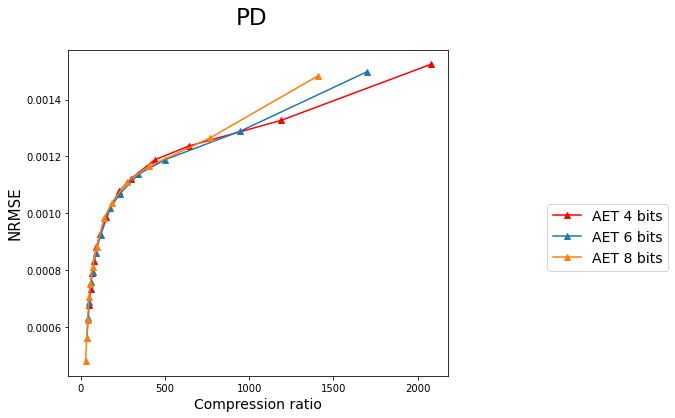

In [37]:
# New results

# PD

fig, axis = plt.subplots(1,1, figsize=(6.8*1,6))
axis.plot(compression_ratio_fixed_cost_AET3d_4bits[:], f0f_rel_rmse_ornl_AET3d_4bits[:], '-^r', label='AET 4 bits')
#axis.plot(compression_ratio_fixed_cost_AET3d_4bits_M1[:], f0f_rel_rmse_ornl_AET3d_4bits_M1[:], '-^b', label='AET 1 subquantizer')
axis.plot(compression_ratio_fixed_cost_AET3d_6bits[:], f0f_rel_rmse_ornl_AET3d_6bits[:], '-^', label='AET 6 bits')
axis.plot(compression_ratio_fixed_cost_AET3d_8bits[:], f0f_rel_rmse_ornl_AET3d_8bits[:], '-^', label='AET 8 bits')

axis.set_xlabel('Compression ratio', fontsize=14)
axis.set_ylabel('NRMSE', fontsize=15)

axis.legend(loc="lower right", bbox_to_anchor=(1.6, 0.3), fontsize=14)
#plt.subplots_adjust(wspace=0.25)
plt.suptitle('PD',fontsize=23)